In [1]:
import l2f_tda as tda
import numpy as np
import pandas as pd
import gudhi as gd
import sklearn as sk
import dask_ml as daml
import pickle as pkl
from sklearn_tda.hera_wasserstein import wasserstein

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.utils as skutils
from sklearn.model_selection import TimeSeriesSplit, KFold
import sklearn.preprocessing as skprep
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
import keras.layers as klayers
import keras.optimizers as koptimizers
import keras.callbacks as kcallbacks
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [3]:
import keras
import tensorflow as tf

config = tf.ConfigProto( device_count = {'CPU': 48} ) 
config = tf.ConfigProto( device_count = {'GPU': 1} ) 

sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [4]:
pipeline_transform = Pipeline([
    ('sampling', tda.Sampler(removeWeekends=False, samplingPeriod='1h')),
    ('embedding', tda.TakensEmbedder()),
    ('labelling', tda.Labeller()),
    ('diagram', tda.VietorisRipsDiagram()),
    ('distance', tda.DiagramDistance()),
    ('physical', tda.MDS()),
    ('derivatives', tda.Derivatives()),
    ('scaling', tda.ScalerWrapper(copy=True)),
    ('formulation', tda.FormulationTransformer())
])
pipeline_estimate = Pipeline([
    ('regression', tda.KerasRegressorWrapper())
])

pipeline = Pipeline([
    ('sampling', tda.Sampler(removeWeekends=False, samplingPeriod='1h')),
    ('embedding', tda.TakensEmbedder()),
    ('labelling', tda.Labeller()),
    ('diagram', tda.VietorisRipsDiagram()),
    ('distance', tda.DiagramDistance()),
    ('physical', tda.MDS()),
    ('derivatives', tda.Derivatives()),
    ('scaling', tda.ScalerWrapper(copy=True)),
    ('formulation', tda.FormulationTransformer()),
    ('regression', tda.KerasRegressorWrapper())
])

In [5]:
pipeline_transform.get_params()
pipeline_estimate.get_params()
pipeline.get_params()

{'memory': None,
 'steps': [('sampling',
   Sampler(removeWeekends=False, samplingPeriod='1h', samplingType='periodic')),
  ('embedding', TakensEmbedder(innerWindowDuration=5, innerWindowStride=1,
           outerWindowDuration=20, outerWindowStride=2)),
  ('labelling', Labeller(function=<function std at 0x7fa408229b70>)),
  ('diagram', VietorisRipsDiagram(dataType='points', homologyDimensions=[0, 1],
             maxEdgeLength=inf)),
  ('distance',
   DiagramDistance(metric=<built-in function bottleneck_distance>, n_jobs=1)),
  ('physical',
   MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
     n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0)),
  ('derivatives', Derivatives(orders=[0, 1, 2])),
  ('scaling', ScalerWrapper(copy=True, feature_range=(0, 1))),
  ('formulation',
   FormulationTransformer(numberStepsInPast=10, stepInFuture=1)),
  ('regression',
   <l2f_tda.KerasWrapper.KerasRegressorWrapper at 0x7fa37c753d30>)],
 'sampling': Sample

In [6]:
# Sampling
sampling_param = {}
sampling_param_grid = {'sampling__' + k: v for k, v in sampling_param.items()}

# Embedding
embedding_param = {}
embedding_param['outerWindowDuration'] = [ 200 ]
embedding_param['outerWindowStride'] = [ 20 ]
embedding_param['innerWindowDuration'] = [ 20 ]
embedding_param['innerWindowStride'] = [ 2 ]
embedding_param_grid = {'embedding__' + k: v for k, v in embedding_param.items()}

# Diagram
diagram_param = {}
diagram_param['homologyDimensions'] = [ [ 0, 1] ]
diagram_param_grid = {'diagram__' + k: v for k, v in diagram_param.items()}

# Distance
distance_param = {}
distance_param['metric'] = [ gd.bottleneck_distance ]
distance_param_grid = {'distance__' + k: v for k, v in distance_param.items()}

# Physical
physical_param = {}
physical_param['n_components'] = [ 5 ]
physical_param_grid = {'physical__' + k: v for k, v in physical_param.items()}

# Derivatives
derivatives_param = {}
derivatives_param['orders'] = [ [0, 1, 2] ]
derivatives_param_grid = {'derivatives__' + k: v for k, v in derivatives_param.items()}

# Scaling
scaling_param = {}
# scaling_param['scaler'] = [ skprep.MinMaxScaler, skprep.StandardScaler ]
scaling_param_grid = {'scaling__' + k: v for k, v in scaling_param.items()}

# Formulation
formulation_param = {}
formulation_param['numberStepsInPast'] = [ 10 ]
formulation_param['stepInFuture'] = [ 1 ]
formulation_param_grid = {'formulation__' + k: v for k, v in formulation_param.items()}

# Regression
regression_param = {}
regression_param['numberFeatures'] =  [ physical_param['n_components'][0] *  len(derivatives_param['orders'][0]) ]
regression_param['numberStepsInPast'] =  formulation_param['numberStepsInPast']
regression_param['modelSteps'] = [ 
    [
        {'layerClass': klayers.normalization.BatchNormalization},
        {'layerClass': layerClass, 'units': units, 'activation': activation},
        {'layerClass': klayers.Dense, 'units': 1}
] for layerClass in [klayers.SimpleRNN, klayers.GRU, klayers.LSTM] for units in [1, 2] for activation in ['tanh', 'relu', 'elu'] for statefull in [True, False]]\


regression_param['optimizerClass'] = [ koptimizers.Adam, koptimizers.RMSprop ]
regression_param['optimizer_kwargs'] = [ {'lr': lr}
                                         for lr in [0.1, 0.01] ]
# regression_param['callbacks'] = [ [kcallbacks.ModelCheckpoint('./model.sk', monitor='loss', save_best_only=True)] ]
regression_param['loss'] = [ 'mean_squared_error' ]
regression_param['batch_size'] =  [ 50, 100, 200 ]
regression_param['epochs'] =  [ 1000, 2000 ]
regression_param_grid = {'regression__' + k: v for k, v in regression_param.items()}

param_grid_transform = {**sampling_param_grid, **embedding_param_grid, **diagram_param_grid, **distance_param_grid, 
              **physical_param_grid, **derivatives_param_grid, **scaling_param_grid, **formulation_param_grid}
param_grid_estimate = {**regression_param_grid}
param_grid = {**param_grid_transform, ** param_grid_estimate}
print(param_grid_transform)
print(param_grid_estimate)

{'embedding__outerWindowDuration': [200], 'embedding__outerWindowStride': [20], 'embedding__innerWindowDuration': [20], 'embedding__innerWindowStride': [2], 'diagram__homologyDimensions': [[0, 1]], 'distance__metric': [<built-in function bottleneck_distance>], 'physical__n_components': [5], 'derivatives__orders': [[0, 1, 2]], 'formulation__numberStepsInPast': [10], 'formulation__stepInFuture': [1]}
{'regression__numberFeatures': [15], 'regression__numberStepsInPast': [10], 'regression__modelSteps': [[{'layerClass': <class 'keras.layers.normalization.BatchNormalization'>}, {'layerClass': <class 'keras.layers.recurrent.SimpleRNN'>, 'units': 1, 'activation': 'tanh'}, {'layerClass': <class 'keras.layers.core.Dense'>, 'units': 1}], [{'layerClass': <class 'keras.layers.normalization.BatchNormalization'>}, {'layerClass': <class 'keras.layers.recurrent.SimpleRNN'>, 'units': 1, 'activation': 'tanh'}, {'layerClass': <class 'keras.layers.core.Dense'>, 'units': 1}], [{'layerClass': <class 'keras.l

In [7]:
import pickle as pkl

numberTrain = 20000

data = pkl.load(open('example_time_series.pkl', 'rb'))
regime = pkl.load(open('example_regime.pkl', 'rb'))
print(data.shape)
X_train = pd.concat([data[:numberTrain], regime[:numberTrain]], axis = 1)
X_train.columns = range(3)
y_train = np.empty((X_train.shape[0], 1))
X_train

(50000, 1)


,0,1,2
1970-01-01 00:00:00+00:00,10.000000,0,0
1970-01-01 01:00:00+00:00,9.633333,0,0
1970-01-01 02:00:00+00:00,9.386394,0,0
1970-01-01 03:00:00+00:00,9.242918,0,0
1970-01-01 04:00:00+00:00,9.186662,0,0
1970-01-01 05:00:00+00:00,9.202042,0,0
1970-01-01 06:00:00+00:00,9.274441,0,0
1970-01-01 07:00:00+00:00,9.390337,0,0
1970-01-01 08:00:00+00:00,9.537337,0,0
1970-01-01 09:00:00+00:00,9.704184,0,0


In [8]:
numberTest = 10000
X_test = pd.concat([data[numberTrain:numberTrain+numberTest], regime[numberTrain:numberTrain+numberTest]], axis = 1)
X_test.columns = range(3)
y_test = np.empty((X_test.shape[0], 1))
X_test

,0,1,2
1972-04-13 08:00:00+00:00,13.183101,1,1
1972-04-13 09:00:00+00:00,13.170473,1,1
1972-04-13 10:00:00+00:00,13.162156,1,1
1972-04-13 11:00:00+00:00,13.158219,1,1
1972-04-13 12:00:00+00:00,13.158709,1,1
1972-04-13 13:00:00+00:00,13.163658,1,1
1972-04-13 14:00:00+00:00,13.173074,1,1
1972-04-13 15:00:00+00:00,13.186945,1,1
1972-04-13 16:00:00+00:00,13.205239,1,1
1972-04-13 17:00:00+00:00,13.227899,1,1


In [9]:
from dask_ml.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

# from dask.distributed import Client
# client = Client()
# skutils.parallel_backend(backend='multiprocessing')

In [10]:
%%time

cv = TimeSeriesSplit(n_splits = 2)
grid_transform = GridSearchCV(estimator=pipeline_transform, param_grid=param_grid_transform, cv=cv, n_jobs=-1, verbose=100, error_score='raise') #iid=False ???
grid_result_transform = grid_transform.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
Pickling array (shape=(20000,), dtype=datetime64[ns]).
Pickling array (shape=(1, 20000), dtype=float64).
Pickling array (shape=(2, 20000), dtype=int8).
Pickling array (shape=(20000, 1), dtype=float64).
Pickling array (shape=(6668,), dtype=int64).
Pickling array (shape=(6666,), dtype=int64).
Pickling array (shape=(20000,), dtype=datetime64[ns]).
Pickling array (shape=(1, 20000), dtype=float64).
Pickling array (shape=(2, 20000), dtype=int8).
Pickling array (shape=(20000, 1), dtype=float64).
Pickling array (shape=(13334,), dtype=int64).
Pickling array (shape=(6666,), dtype=int64).
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 41.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 41.1min finished
distance:  (991, 991)
(991, 5) (989, 15) (991, 1) (989, 1)
CPU ti

In [11]:
X_train_transformed = grid_result_transform.transform(X_train)
pkl.dump(X_train_transformed, open('X_train_transformed.pkl', 'wb'))

distance:  (991, 991)
(991, 5) (989, 15) (991, 1) (989, 1)


In [12]:
X_test_transformed = grid_result_transform.transform(X_test)
pkl.dump(X_test_transformed, open('X_test_transformed.pkl', 'wb'))

distance:  (1482, 491)
symmetry predict True
(491, 5) (489, 15) (491, 1) (489, 1)


In [13]:
%%time
X_train_transformed = pkl.load(open('X_train_transformed.pkl', 'rb'))

cv = KFold(n_splits=3, shuffle=True)
grid_estimate = GridSearchCV(estimator=pipeline_estimate, param_grid=param_grid_estimate, cv=cv, n_jobs=-1, verbose=100, error_score='raise') #iid=False ???
grid_result_estimate = grid_estimate.fit(X_train_transformed[0], X_train_transformed[1])


Fitting 3 folds for each of 864 candidates, totalling 2592 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
Memmapping (shape=(979, 10, 15), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,),

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmap

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pi

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  3.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(9

[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:  5.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:  5.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  5.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:  5.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:  5.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:  5.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:  8.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed:  8.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:  8.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  8.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  8.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:  8.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 16.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed: 16.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed: 16.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 16.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed: 16.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

/home/shared_envs/research_env/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 23.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed: 23.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pi

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 24.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 219 tasks      | elapsed: 24.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed: 24.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8

[Parallel(n_jobs=-1)]: Done 239 tasks      | elapsed: 26.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 26.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed: 30.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed: 32.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 32.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed: 34.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed: 34.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed: 42.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 309 tasks      | elapsed: 42.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 310 tasks      | elapsed: 42.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 331 tasks      | elapsed: 44.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 44.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed: 52.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 355 tasks      | elapsed: 52.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed: 52.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed: 54.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed: 54.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 379 tasks      | elapsed: 54.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 62.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 62.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pi

[Parallel(n_jobs=-1)]: Done 422 tasks      | elapsed: 63.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 423 tasks      | elapsed: 64.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed: 64.3min
[Parallel(n_jobs=-1)]: Done 425 tasks      | elapsed: 64.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8

[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed: 68.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 68.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 447 tasks      | elapsed: 68.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 469 tasks      | elapsed: 69.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)

[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed: 73.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 491 tasks      | elapsed: 73.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed: 73.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed: 75.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed: 75.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 515 tasks      | elapsed: 75.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed: 78.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 78.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed: 78.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed: 80.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 561 tasks      | elapsed: 81.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 81.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed: 93.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed: 94.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 585 tasks      | elapsed: 94.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed: 96.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 607 tasks      | elapsed: 97.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed: 97.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), 

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 630 tasks      | elapsed: 109.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 631 tasks      | elapsed: 109.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).


Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 651 tasks      | elapsed: 112.4min
[Parallel(n_jobs=-1)]: Done 652 tasks      | elapsed: 112.4min
[Parallel(n_jobs=-1)]: Done 653 tasks      | elapsed: 112.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed: 124.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1

[Parallel(n_jobs=-1)]: Done 697 tasks      | elapsed: 128.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1

[Parallel(n_jobs=-1)]: Done 719 tasks      | elapsed: 131.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed: 132.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 721 tasks      | elapsed: 143.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

[Parallel(n_jobs=-1)]: Done 742 tasks      | elapsed: 147.4min
[Parallel(n_jobs=-1)]: Done 743 tasks      | elapsed: 147.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed: 147.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

[Parallel(n_jobs=-1)]: Done 765 tasks      | elapsed: 151.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 766 tasks      | elapsed: 151.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 767 tasks      | elapsed: 151.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed: 166.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 789 tasks      | elapsed: 166.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 790 tasks      | elapsed: 166.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed: 171.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed: 172.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed: 172.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 835 tasks      | elapsed: 185.0min
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed: 185.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 837 tasks      | elapsed: 185.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 187.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 859 tasks      | elapsed: 187.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).


[Parallel(n_jobs=-1)]: Done 880 tasks      | elapsed: 188.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 881 tasks      | elapsed: 188.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 882 tasks      | elapsed: 188.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 905 tasks      | elapsed: 189.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 906 tasks      | elapsed: 189.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).


[Parallel(n_jobs=-1)]: Done 927 tasks      | elapsed: 190.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed: 190.2min
[Parallel(n_jobs=-1)]: Done 929 tasks      | elapsed: 190.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed: 191.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 951 tasks      | elapsed: 191.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 191.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

[Parallel(n_jobs=-1)]: Done 973 tasks      | elapsed: 191.9min
[Parallel(n_jobs=-1)]: Done 974 tasks      | elapsed: 191.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 975 tasks      | elapsed: 192.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

[Parallel(n_jobs=-1)]: Done 996 tasks      | elapsed: 192.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 192.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 998 tasks      | elapsed: 192.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1

[Parallel(n_jobs=-1)]: Done 1019 tasks      | elapsed: 196.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1020 tasks      | elapsed: 196.1min
[Parallel(n_jobs=-1)]: Done 1021 tasks      | elapsed: 196.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed: 196.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864

[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed: 196.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1043 tasks      | elapsed: 196.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1044 tasks      | elapsed: 196.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed: 200.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed: 200.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1087 tasks      | elapsed: 201.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed: 201.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1111 tasks      | elapsed: 204.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed: 204.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmap

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1156 tasks      | elapsed: 209.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1157 tasks      | elapsed: 209.2min
[Parallel(n_jobs=-1)]: Done 1158 tasks      | elapsed: 209.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1175 tasks      | elapsed: 210.1min
[Parallel(n_jobs=-1)]: Done 1176 tasks      | elapsed: 210.1min
[Parallel(n_jobs=-1)]: Done 1177 tasks      | elapsed: 210.1min
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed: 210.1min
[Parallel(n_jobs=-1)]: Done 1179 tasks      | elapsed: 210.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1180 tasks      | elapsed: 210.2min
Memm

[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed: 211.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1201 tasks      | elapsed: 213.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed: 213.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1223 tasks      | elapsed: 215.4min
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed: 215.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 216.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1247 tasks      | elapsed: 216.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed: 216.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1269 tasks      | elapsed: 220.5min
[Parallel(n_jobs=-1)]: Done 1270 tasks      | elapsed: 220.5min
[Parallel(n_jobs=-1)]: Done 1271 tasks      | elapsed: 220.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1291 tasks      | elapsed: 221.3min
[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed: 221.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1293 tasks      | elapsed: 221.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1314 tasks      | elapsed: 223.7min
[Parallel(n_jobs=-1)]: Done 1315 tasks      | elapsed: 223.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed: 223.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1337 tasks      | elapsed: 224.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed: 224.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1339 tasks      | elapsed: 224.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed: 226.7min
[Parallel(n_jobs=-1)]: Done 1361 tasks      | elapsed: 226.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed: 226.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1379 tasks      | elapsed: 227.7min
[Parallel(n_jobs=-1)]: Done 1380 tasks      | elapsed: 227.7min
[Parallel(n_jobs=-1)]: Done 1381 tasks      | elapsed: 227.7min
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed: 227.7min
[Parallel(n_jobs=-1)]: Done 1383 tasks      | elapsed: 227.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1384 tasks      | elapsed: 227.7min
[Par

[Parallel(n_jobs=-1)]: Done 1406 tasks      | elapsed: 229.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1407 tasks      | elapsed: 229.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1408 tasks      | elapsed: 229.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1429 tasks      | elapsed: 230.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1430 tasks      | elapsed: 231.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1451 tasks      | elapsed: 237.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1452 tasks      | elapsed: 237.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1453 tasks      | elapsed: 237.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1475 tasks      | elapsed: 239.2min
[Parallel(n_jobs=-

[Parallel(n_jobs=-1)]: Done 1495 tasks      | elapsed: 245.9min
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed: 245.9min
[Parallel(n_jobs=-1)]: Done 1497 tasks      | elapsed: 245.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1498 tasks      | elapsed: 246.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1519 tasks      | elapsed: 247.4min
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed: 247.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1541 tasks      | elapsed: 254.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1542 tasks      | elapsed: 254.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1543 tasks      | elapsed: 254.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed: 255.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1565 tasks      | elapsed: 255.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed: 263.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1587 tasks      | elapsed: 264.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed: 264.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1607 tasks      | elapsed: 265.9min
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed: 265.9min
[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed: 265.9min
[Parallel(n_jobs=-1)]: Done 1610 tasks      | elapsed: 265.9min
[Parallel(n_jobs=-1)]: Done 1611 tasks      | elapsed: 265.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed: 268.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1633 tasks      | elapsed: 273.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1654 tasks      | elapsed: 276.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1655 tasks      | elapsed: 276.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1677 tasks      | elapsed: 278.6min
[Parallel(n_jobs=-1)]: Done 1678 tasks      | elapsed: 278.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1679 tasks      | elapsed: 278.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1700 tasks      | elapsed: 287.0min
[Parallel(n_jobs=-

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1722 tasks      | elapsed: 288.5min
[Parallel(n_jobs=-1)]: Done 1723 tasks      | elapsed: 288.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1724 tasks      | elapsed: 288.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1745 tasks      | elapsed: 289.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1746 tasks      | elapsed: 289.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1767 tasks      | elapsed: 289.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-

[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed: 290.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1791 tasks      | elapsed: 290.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 290.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1813 tasks      | elapsed: 290.7min
[Parallel(n_jobs=-1)]: Done 1814 tasks      | elapsed: 290.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1815 tasks      | elapsed: 290.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1836 tasks      | elapsed: 291.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1861 tasks      | elapsed: 291.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmap

[Parallel(n_jobs=-1)]: Done 1904 tasks      | elapsed: 294.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1905 tasks      | elapsed: 294.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed: 295.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1927 tasks      | elapsed: 298.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1928 tasks      | elapsed: 298.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 1950 tasks      | elapsed: 299.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1951 tasks      | elapsed: 299.6min
[Parallel(n_jobs=-1)]: Done 1952 tasks      | elapsed: 299.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 1972 tasks      | elapsed: 301.3min
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed: 301.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1974 tasks      | elapsed: 301.4min
[Parallel(n_jobs=-1)]: Done 1975 tasks      | elapsed: 301.4min
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed: 301.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm

[Parallel(n_jobs=-1)]: Done 1997 tasks      | elapsed: 301.9min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1998 tasks      | elapsed: 302.0min
[Parallel(n_jobs=-1)]: Done 1999 tasks      | elapsed: 302.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 2018 tasks      | elapsed: 303.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2019 tasks      | elapsed: 304.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2020 tasks      | elapsed: 304.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 2041 tasks      | elapsed: 305.1min
[Parallel(n_jobs=-1)]: Done 2042 tasks      | elapsed: 305.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2043 tasks      | elapsed: 305.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 2063 tasks      | elapsed: 306.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed: 306.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2065 tasks      | elapsed: 306.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2086 tasks      | elapsed: 308.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2087 tasks      | elapsed: 308.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 2109 tasks      | elapsed: 309.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2130 tasks      | elapsed: 311.5min
[Parallel(n_jobs=-1)]: Done 2131 tasks      | elapsed: 311.5min
[Parallel(n_jobs=-1)]: Done 2132 tasks      | elapsed: 311.5min
[Parallel(n_jobs=-1)]: Done 2133 tasks      | elapsed: 311.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864

[Parallel(n_jobs=-1)]: Done 2153 tasks      | elapsed: 312.2min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed: 312.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 2176 tasks      | elapsed: 313.6min
[Parallel(n_jobs=-1)]: Done 2177 tasks      | elapsed: 313.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2178 tasks      | elapsed: 313.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

[Parallel(n_jobs=-1)]: Done 2199 tasks      | elapsed: 314.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2200 tasks      | elapsed: 314.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2201 tasks      | elapsed: 314.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2222 tasks      | elapsed: 315.7min
[Parallel(n_jobs=-1)]: Done 2223 tasks      | elapsed: 315.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 2242 tasks      | elapsed: 316.1min
[Parallel(n_jobs=-1)]: Done 2243 tasks      | elapsed: 316.1min
[Parallel(n_jobs=-1)]: Done 2244 tasks      | elapsed: 316.1min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2245 tasks      | elapsed: 316.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2246 tasks      | elapsed: 316.3min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm

[Parallel(n_jobs=-1)]: Done 2266 tasks      | elapsed: 317.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2267 tasks      | elapsed: 317.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2268 tasks      | elapsed: 317.7min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 318.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-

[Parallel(n_jobs=-1)]: Done 2311 tasks      | elapsed: 322.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=

[Parallel(n_jobs=-1)]: Done 2334 tasks      | elapsed: 323.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2335 tasks      | elapsed: 323.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed: 327.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2357 tasks      | elapsed: 327.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2358 tasks      | elapsed: 327.4min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2379 tasks      | elapsed: 328.6min
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed: 328.6min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

[Parallel(n_jobs=-1)]: Done 2401 tasks      | elapsed: 331.9min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed: 332.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2403 tasks      | elapsed: 332.2min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2425 tasks      | elapsed: 333.5min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 333.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 334.5min
[Parallel(n_jobs=-1)]: Done 2447 tasks      | elapsed: 334.5min
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed: 334.5min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2469 tasks      | elapsed: 339.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2470 tasks      | elapsed: 339.8min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64)

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2492 tasks      | elapsed: 341.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 2493 tasks      | elapsed: 341.0min
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64)

Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(652,), dtype=int64).
Pickling array (shape=(327,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_13718_4492964927/13718-140339134544864-0d1d5f8ab94e4b648b404b900a6f29b0.pkl
Pickling array (shape=(979, 1), dtype=float64).
Pickling array (shape=(653,), dtype=int64).
Pickling array (shape=(326,), dtype=int64).
Memmapping (shape=(979, 10, 15), dtype=float64) to old file /dev/shm/joblib_memmap

/home/shared_envs/research_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Epoch 1/1000
979/979 [==============================] - 1s 684us/step - loss: 1.9095 - acc: 0.0000e+00
Epoch 2/1000
979/979 [==============================] - 0s 196us/step - loss: 1.3608 - acc: 0.0000e+00
Epoch 3/1000
979/979 [==============================] - 0s 209us/step - loss: 1.0132 - acc: 0.0000e+00
Epoch 4/1000
979/979 [==============================] - 0s 186us/step - loss: 0.7692 - acc: 0.0000e+00
Epoch 5/1000
979/979 [==============================] - 0s 188us/step - loss: 0.6218 - acc: 0.0000e+00
Epoch 6/1000
979/979 [==============================] - 0s 172us/step - loss: 0.5039 - acc: 0.0000e+00
Epoch 7/1000
979/979 [==============================] - 0s 201us/step - loss: 0.4200 - acc: 0.0000e+00
Epoch 8/1000
979/979 [==============================] - 0s 203us/step - loss: 0.3383 - acc: 0.0000e+00
Epoch 9/1000
979/979 [==============================] - 0s 209us/step - loss: 0.2901 - acc: 0.0000e+00
Epoch 10/1000
979/979 [==============================] - 0s 207us/step - 

979/979 [==============================] - 0s 169us/step - loss: 0.0601 - acc: 0.0000e+00
Epoch 80/1000
979/979 [==============================] - 0s 180us/step - loss: 0.0562 - acc: 0.0000e+00
Epoch 81/1000
979/979 [==============================] - 0s 175us/step - loss: 0.0564 - acc: 0.0000e+00
Epoch 82/1000
979/979 [==============================] - 0s 201us/step - loss: 0.0533 - acc: 0.0000e+00
Epoch 83/1000
979/979 [==============================] - 0s 211us/step - loss: 0.0523 - acc: 0.0000e+00
Epoch 84/1000
979/979 [==============================] - 0s 213us/step - loss: 0.0564 - acc: 0.0000e+00
Epoch 85/1000
979/979 [==============================] - 0s 210us/step - loss: 0.0624 - acc: 0.0000e+00
Epoch 86/1000
979/979 [==============================] - 0s 209us/step - loss: 0.0640 - acc: 0.0000e+00
Epoch 87/1000
979/979 [==============================] - 0s 206us/step - loss: 0.0573 - acc: 0.0000e+00
Epoch 88/1000
979/979 [==============================] - 0s 180us/step - loss:

979/979 [==============================] - 0s 172us/step - loss: 0.0510 - acc: 0.0000e+00
Epoch 158/1000
979/979 [==============================] - 0s 176us/step - loss: 0.0474 - acc: 0.0000e+00
Epoch 159/1000
979/979 [==============================] - 0s 193us/step - loss: 0.0473 - acc: 0.0000e+00
Epoch 160/1000
979/979 [==============================] - 0s 208us/step - loss: 0.0462 - acc: 0.0000e+00
Epoch 161/1000
979/979 [==============================] - 0s 208us/step - loss: 0.0484 - acc: 0.0000e+00
Epoch 162/1000
979/979 [==============================] - 0s 193us/step - loss: 0.0476 - acc: 0.0000e+00
Epoch 163/1000
979/979 [==============================] - 0s 202us/step - loss: 0.0490 - acc: 0.0000e+00
Epoch 164/1000
979/979 [==============================] - 0s 190us/step - loss: 0.0496 - acc: 0.0000e+00
Epoch 165/1000
979/979 [==============================] - 0s 174us/step - loss: 0.0515 - acc: 0.0000e+00
Epoch 166/1000
979/979 [==============================] - 0s 191us/ste

979/979 [==============================] - 0s 181us/step - loss: 0.0403 - acc: 0.0000e+00
Epoch 236/1000
979/979 [==============================] - 0s 177us/step - loss: 0.0391 - acc: 0.0000e+00
Epoch 237/1000
979/979 [==============================] - 0s 177us/step - loss: 0.0439 - acc: 0.0000e+00
Epoch 238/1000
979/979 [==============================] - 0s 207us/step - loss: 0.0406 - acc: 0.0000e+00
Epoch 239/1000
979/979 [==============================] - 0s 212us/step - loss: 0.0782 - acc: 0.0000e+00
Epoch 240/1000
979/979 [==============================] - 0s 210us/step - loss: 0.0375 - acc: 0.0000e+00
Epoch 241/1000
979/979 [==============================] - 0s 190us/step - loss: 0.0401 - acc: 0.0000e+00
Epoch 242/1000
979/979 [==============================] - 0s 211us/step - loss: 0.0401 - acc: 0.0000e+00
Epoch 243/1000
979/979 [==============================] - 0s 211us/step - loss: 0.0377 - acc: 0.0000e+00
Epoch 244/1000
979/979 [==============================] - 0s 202us/ste

979/979 [==============================] - 0s 176us/step - loss: 0.0380 - acc: 0.0000e+00
Epoch 314/1000
979/979 [==============================] - 0s 179us/step - loss: 0.0374 - acc: 0.0000e+00
Epoch 315/1000
979/979 [==============================] - 0s 182us/step - loss: 0.0420 - acc: 0.0000e+00
Epoch 316/1000
979/979 [==============================] - 0s 188us/step - loss: 0.0502 - acc: 0.0000e+00
Epoch 317/1000
979/979 [==============================] - 0s 208us/step - loss: 0.0409 - acc: 0.0000e+00
Epoch 318/1000
979/979 [==============================] - 0s 212us/step - loss: 0.0396 - acc: 0.0000e+00
Epoch 319/1000
979/979 [==============================] - 0s 209us/step - loss: 0.0379 - acc: 0.0000e+00
Epoch 320/1000
979/979 [==============================] - 0s 209us/step - loss: 0.0395 - acc: 0.0000e+00
Epoch 321/1000
979/979 [==============================] - 0s 208us/step - loss: 0.0371 - acc: 0.0000e+00
Epoch 322/1000
979/979 [==============================] - 0s 213us/ste

979/979 [==============================] - 0s 182us/step - loss: 0.0219 - acc: 0.0000e+00
Epoch 392/1000
979/979 [==============================] - 0s 190us/step - loss: 0.0212 - acc: 0.0000e+00
Epoch 393/1000
979/979 [==============================] - 0s 212us/step - loss: 0.0252 - acc: 0.0000e+00
Epoch 394/1000
979/979 [==============================] - 0s 214us/step - loss: 0.0224 - acc: 0.0000e+00
Epoch 395/1000
979/979 [==============================] - 0s 210us/step - loss: 0.0251 - acc: 0.0000e+00
Epoch 396/1000
979/979 [==============================] - 0s 208us/step - loss: 0.0351 - acc: 0.0000e+00
Epoch 397/1000
979/979 [==============================] - 0s 206us/step - loss: 0.0232 - acc: 0.0000e+00
Epoch 398/1000
979/979 [==============================] - 0s 190us/step - loss: 0.0251 - acc: 0.0000e+00
Epoch 399/1000
979/979 [==============================] - 0s 196us/step - loss: 0.0237 - acc: 0.0000e+00
Epoch 400/1000
979/979 [==============================] - 0s 209us/ste

979/979 [==============================] - 0s 179us/step - loss: 0.0268 - acc: 0.0000e+00
Epoch 470/1000
979/979 [==============================] - 0s 189us/step - loss: 0.0233 - acc: 0.0000e+00
Epoch 471/1000
979/979 [==============================] - 0s 204us/step - loss: 0.0247 - acc: 0.0000e+00
Epoch 472/1000
979/979 [==============================] - 0s 207us/step - loss: 0.0210 - acc: 0.0000e+00
Epoch 473/1000
979/979 [==============================] - 0s 205us/step - loss: 0.0224 - acc: 0.0000e+00
Epoch 474/1000
979/979 [==============================] - 0s 192us/step - loss: 0.0563 - acc: 0.0000e+00
Epoch 475/1000
979/979 [==============================] - 0s 183us/step - loss: 0.0235 - acc: 0.0000e+00
Epoch 476/1000
979/979 [==============================] - 0s 204us/step - loss: 0.0218 - acc: 0.0000e+00
Epoch 477/1000
979/979 [==============================] - 0s 207us/step - loss: 0.0253 - acc: 0.0000e+00
Epoch 478/1000
979/979 [==============================] - 0s 209us/ste

979/979 [==============================] - 0s 178us/step - loss: 0.0248 - acc: 0.0000e+00
Epoch 548/1000
979/979 [==============================] - 0s 206us/step - loss: 0.0249 - acc: 0.0000e+00
Epoch 549/1000
979/979 [==============================] - 0s 192us/step - loss: 0.0194 - acc: 0.0000e+00
Epoch 550/1000
979/979 [==============================] - 0s 193us/step - loss: 0.0335 - acc: 0.0000e+00
Epoch 551/1000
979/979 [==============================] - 0s 211us/step - loss: 0.0224 - acc: 0.0000e+00
Epoch 552/1000
979/979 [==============================] - 0s 207us/step - loss: 0.0259 - acc: 0.0000e+00
Epoch 553/1000
979/979 [==============================] - 0s 201us/step - loss: 0.0232 - acc: 0.0000e+00
Epoch 554/1000
979/979 [==============================] - 0s 207us/step - loss: 0.0294 - acc: 0.0000e+00
Epoch 555/1000
979/979 [==============================] - 0s 211us/step - loss: 0.0255 - acc: 0.0000e+00
Epoch 556/1000
979/979 [==============================] - 0s 210us/ste

979/979 [==============================] - 0s 189us/step - loss: 0.0265 - acc: 0.0000e+00
Epoch 626/1000
979/979 [==============================] - 0s 172us/step - loss: 0.0208 - acc: 0.0000e+00
Epoch 627/1000
979/979 [==============================] - 0s 175us/step - loss: 0.0207 - acc: 0.0000e+00
Epoch 628/1000
979/979 [==============================] - 0s 176us/step - loss: 0.0281 - acc: 0.0000e+00
Epoch 629/1000
979/979 [==============================] - 0s 205us/step - loss: 0.0505 - acc: 0.0000e+00
Epoch 630/1000
979/979 [==============================] - 0s 210us/step - loss: 0.0268 - acc: 0.0000e+00
Epoch 631/1000
979/979 [==============================] - 0s 207us/step - loss: 0.0405 - acc: 0.0000e+00
Epoch 632/1000
979/979 [==============================] - 0s 205us/step - loss: 0.0220 - acc: 0.0000e+00
Epoch 633/1000
979/979 [==============================] - 0s 200us/step - loss: 0.0230 - acc: 0.0000e+00
Epoch 634/1000
979/979 [==============================] - 0s 210us/ste

979/979 [==============================] - 0s 175us/step - loss: 0.0259 - acc: 0.0000e+00
Epoch 704/1000
979/979 [==============================] - 0s 174us/step - loss: 0.0241 - acc: 0.0000e+00
Epoch 705/1000
979/979 [==============================] - 0s 205us/step - loss: 0.0187 - acc: 0.0000e+00
Epoch 706/1000
979/979 [==============================] - 0s 215us/step - loss: 0.0235 - acc: 0.0000e+00
Epoch 707/1000
979/979 [==============================] - 0s 213us/step - loss: 0.0228 - acc: 0.0000e+00
Epoch 708/1000
979/979 [==============================] - 0s 211us/step - loss: 0.0325 - acc: 0.0000e+00
Epoch 709/1000
979/979 [==============================] - 0s 206us/step - loss: 0.0242 - acc: 0.0000e+00
Epoch 710/1000
979/979 [==============================] - 0s 183us/step - loss: 0.0267 - acc: 0.0000e+00
Epoch 711/1000
979/979 [==============================] - 0s 198us/step - loss: 0.0309 - acc: 0.0000e+00
Epoch 712/1000
979/979 [==============================] - 0s 195us/ste

979/979 [==============================] - 0s 178us/step - loss: 0.0248 - acc: 0.0000e+00
Epoch 782/1000
979/979 [==============================] - 0s 170us/step - loss: 0.0209 - acc: 0.0000e+00
Epoch 783/1000
979/979 [==============================] - 0s 172us/step - loss: 0.0242 - acc: 0.0000e+00
Epoch 784/1000
979/979 [==============================] - 0s 188us/step - loss: 0.0265 - acc: 0.0000e+00
Epoch 785/1000
979/979 [==============================] - 0s 204us/step - loss: 0.0198 - acc: 0.0000e+00
Epoch 786/1000
979/979 [==============================] - 0s 194us/step - loss: 0.0229 - acc: 0.0000e+00
Epoch 787/1000
979/979 [==============================] - 0s 168us/step - loss: 0.0222 - acc: 0.0000e+00
Epoch 788/1000
979/979 [==============================] - 0s 167us/step - loss: 0.0199 - acc: 0.0000e+00
Epoch 789/1000
979/979 [==============================] - 0s 170us/step - loss: 0.0424 - acc: 0.0000e+00
Epoch 790/1000
979/979 [==============================] - 0s 181us/ste

979/979 [==============================] - 0s 199us/step - loss: 0.0226 - acc: 0.0000e+00
Epoch 860/1000
979/979 [==============================] - 0s 195us/step - loss: 0.0777 - acc: 0.0000e+00
Epoch 861/1000
979/979 [==============================] - 0s 193us/step - loss: 0.0215 - acc: 0.0000e+00
Epoch 862/1000
979/979 [==============================] - 0s 168us/step - loss: 0.0202 - acc: 0.0000e+00
Epoch 863/1000
979/979 [==============================] - 0s 173us/step - loss: 0.0244 - acc: 0.0000e+00
Epoch 864/1000
979/979 [==============================] - 0s 180us/step - loss: 0.0219 - acc: 0.0000e+00
Epoch 865/1000
979/979 [==============================] - 0s 200us/step - loss: 0.1408 - acc: 0.0000e+00
Epoch 866/1000
979/979 [==============================] - 0s 176us/step - loss: 0.0218 - acc: 0.0000e+00
Epoch 867/1000
979/979 [==============================] - 0s 201us/step - loss: 0.0233 - acc: 0.0000e+00
Epoch 868/1000
979/979 [==============================] - 0s 195us/ste

979/979 [==============================] - 0s 208us/step - loss: 0.0305 - acc: 0.0000e+00
Epoch 938/1000
979/979 [==============================] - 0s 213us/step - loss: 0.0230 - acc: 0.0000e+00
Epoch 939/1000
979/979 [==============================] - 0s 202us/step - loss: 0.0243 - acc: 0.0000e+00
Epoch 940/1000
979/979 [==============================] - 0s 171us/step - loss: 0.0176 - acc: 0.0000e+00
Epoch 941/1000
979/979 [==============================] - 0s 173us/step - loss: 0.0244 - acc: 0.0000e+00
Epoch 942/1000
979/979 [==============================] - 0s 184us/step - loss: 0.0243 - acc: 0.0000e+00
Epoch 943/1000
979/979 [==============================] - 0s 207us/step - loss: 0.0292 - acc: 0.0000e+00
Epoch 944/1000
979/979 [==============================] - 0s 206us/step - loss: 0.0212 - acc: 0.0000e+00
Epoch 945/1000
979/979 [==============================] - 0s 208us/step - loss: 0.0221 - acc: 0.0000e+00
Epoch 946/1000
979/979 [==============================] - 0s 207us/ste

In [15]:
# summarize results
print("Best: %f using %s" % (grid_result_estimate.best_score_, grid_result_estimate.best_params_))
means = grid_result_estimate.cv_results_['mean_test_score']
stds = grid_result_estimate.cv_results_['std_test_score']
params = grid_result_estimate.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.059498 using {'regression__batch_size': 100, 'regression__epochs': 1000, 'regression__loss': 'mean_squared_error', 'regression__modelSteps': [{'layerClass': <class 'keras.layers.normalization.BatchNormalization'>}, {'layerClass': <class 'keras.layers.recurrent.LSTM'>, 'units': 2, 'activation': 'tanh'}, {'layerClass': <class 'keras.layers.core.Dense'>, 'units': 1}], 'regression__numberFeatures': 15, 'regression__numberStepsInPast': 10, 'regression__optimizerClass': <class 'keras.optimizers.RMSprop'>, 'regression__optimizer_kwargs': {'lr': 0.01}}
-0.712843 (0.128132) with: {'regression__batch_size': 50, 'regression__epochs': 1000, 'regression__loss': 'mean_squared_error', 'regression__modelSteps': [{'layerClass': <class 'keras.layers.normalization.BatchNormalization'>}, {'layerClass': <class 'keras.layers.recurrent.SimpleRNN'>, 'units': 1, 'activation': 'tanh'}, {'layerClass': <class 'keras.layers.core.Dense'>, 'units': 1}], 'regression__numberFeatures': 15, 'regression__numberS

In [16]:
y_predict_train, y_true_train = grid_result_estimate.predict(X_train_transformed)

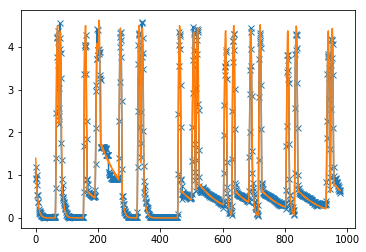

In [17]:
plt.plot(y_predict_train, marker='x')
plt.plot(y_true_train)

In [21]:
X_test_transformed = pkl.load(open('X_test_transformed.pkl', 'rb'))
y_predict_test, y_true_test = grid_result_estimate.predict(X_test_transformed)

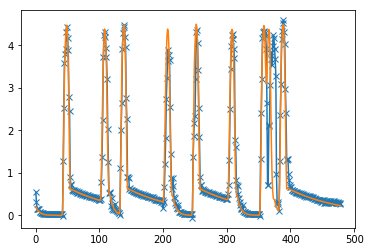

In [22]:
plt.plot(y_predict_test, marker='x')
plt.plot(y_true_test)